# Working with Custom Models

In this tutorial we will cover how we can generate visualisations from custom PyTorch models and introduce the best practices to follow in order to get quality results. 

We will begin by looking at the visual.wrap helper function that should work for most models before going into the subwrappers that visual uses and how we can write models that synergise well with them.  

## Install visual 

In [1]:
try:
    import visual
except:
    !pip install -q visual
    import visual
    
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer
    
print(visual.__version__)

You should consider upgrading via the 'pip install --upgrade pip' command.
0.1.0


## Wrap

Let us show how we can quickly retrieve a torchvision model and wrap it to prepare for visualisation.

In [2]:
from torchvision.models import resnet18
from visual.transforms import RandomRotate, RandomScale, Compose

model = visual.wrap(resnet18(True))
print(model.layer_names)

['model', 'model_conv1', 'model_bn1', 'model_relu', 'model_relu_redirected_module', 'model_relu_old_module', 'model_maxpool', 'model_layer1', 'model_layer1_0', 'model_layer1_0_conv1', 'model_layer1_0_bn1', 'model_layer1_0_relu', 'model_layer1_0_conv2', 'model_layer1_0_bn2', 'model_layer1_1', 'model_layer1_1_conv1', 'model_layer1_1_bn1', 'model_layer1_1_relu', 'model_layer1_1_conv2', 'model_layer1_1_bn2', 'model_layer2', 'model_layer2_0', 'model_layer2_0_conv1', 'model_layer2_0_bn1', 'model_layer2_0_relu', 'model_layer2_0_conv2', 'model_layer2_0_bn2', 'model_layer2_0_downsample', 'model_layer2_0_downsample_0', 'model_layer2_0_downsample_1', 'model_layer2_1', 'model_layer2_1_conv1', 'model_layer2_1_bn1', 'model_layer2_1_relu', 'model_layer2_1_conv2', 'model_layer2_1_bn2', 'model_layer3', 'model_layer3_0', 'model_layer3_0_conv1', 'model_layer3_0_bn1', 'model_layer3_0_relu', 'model_layer3_0_conv2', 'model_layer3_0_bn2', 'model_layer3_0_downsample', 'model_layer3_0_downsample_0', 'model_lay

We can then visualise the 256th feature corresponding to the class "Newfoundland Dog". 

/home/matt/miniconda3/lib/python3.6/site-packages/torch/nn/functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/matt/miniconda3/lib/python3.6/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/matt/miniconda3/lib/python3.6/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(m

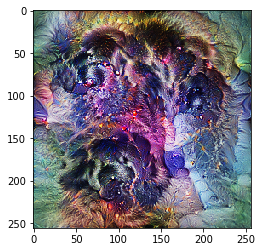

In [3]:
transforms = Compose([
    RandomRotate(list(range(-30, 30, 5))),
    RandomScale([0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2]),
])

%matplotlib inline

crit = visual.Channel(256, 'model_fc')
img = visual.image((3, 256, 256), transform=transforms, correlate=True, fft=True)
a = visual.BasicAscent(img, crit, verbose=2).to_pyplot().run(model, device='cuda')

Visual.wrap is a simple way to prepare a model for visualisation and works quite well for most standard models. Under 
the hood all it does is wrap your model with two modules, one which redirects the ReLU units and one which gets and 
saves a reference to all intermediate layers so we can access them with our criterions.

Lets look at a few different model definitions and the intermediate layers which ``visual`` finds when wrapping. This will show us which model building styles are best suited to visuals wrapping methods. 

In [4]:
from torch import nn

class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 16, 3, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, 2)
        self.conv3 = nn.Conv2d(32, 64, stride=2, kernel_size=3)
        self.fc = nn.Linear(576, 10)
        
    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x, True)
        x = self.conv2(x)
        x = F.relu(x, True)
        x = self.conv3(x)
        x = F.relu(x, True)
        x = self.fc(x.flatten(1))
        return x
    
model = SimpleModel()
model = visual.wrap(model)
print(model.layer_names)

['model', 'model_conv', 'model_conv2', 'model_conv3', 'model_fc']


Here we can see that we pick up the conv layers but ``visual`` did not notice the ReLU layers. Unfortunately, the way visual parses a model to find intermediate layers is to navigate the children of each module and wrap them with a version that stores a reference to its output. When using functional methods, since they are not registered as children of a PyTorch model, ``visual`` cannot locate or wrap them. Even worse is that we have used the inplace functional ReLUs which means we the output referenced by the wrapped convolution modules actually points to the post-ReLU values. 

So the first thing we should do is replace functional methods with their modular equivelents. 
Lets do this for the Simple Model. 

In [5]:
class BetterModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Sequentials with separate ReLU modules are properly parsed
        self.convs = nn.Sequential(
            nn.Conv2d(3, 16, stride=2, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16, 32, stride=2, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 64, stride=2, kernel_size=3),
            nn.ReLU())
        # Individual layers are also properly parsed 
        self.fc = nn.Linear(576, 10)
        
    def forward(self, x):
        x = self.convs(x)
        x = self.fc(x.flatten(1))
        return x
        
better_model = BetterModel()
better_model = visual.wrap(better_model)
print(better_model.layer_names)

['model', 'model_convs', 'model_convs_0', 'model_convs_1', 'model_convs_2', 'model_convs_3', 'model_convs_4', 'model_convs_5', 'model_fc']


Now we have access to all the layers including pre and post-ReLU. This is better, but the layer names are now not particularly informative. These names are based off of the registered names in PyTorch, so one way to get more informative names is to register the submodules differently. Consider the following model. 

In [6]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, stride, kernel_size):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, stride=stride, kernel_size=kernel_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x
    
    
class FinalModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Leads to better layer names
        self.convs = nn.Sequential(
            ConvModule(3, 16, stride=2, kernel_size=3),
            ConvModule(16, 32, stride=2, kernel_size=3),
            ConvModule(32, 64, stride=2, kernel_size=3),
            )
        # Individual layers are also properly parsed 
        self.fc = nn.Linear(576, 10)        
        
    def forward(self, x):
        x = self.convs(x)
        x = self.fc(x.flatten(1))
        return x
    
final_model = FinalModel()
final_model = visual.wrap(final_model)
print(final_model.layer_names)

['model', 'model_convs', 'model_convs_0', 'model_convs_0_conv', 'model_convs_0_relu', 'model_convs_1', 'model_convs_1_conv', 'model_convs_1_relu', 'model_convs_2', 'model_convs_2_conv', 'model_convs_2_relu', 'model_fc']


Now that we have defined a submodule which registers the conv and relu under proper names we get much more informative layer names. We could also add comonly used layers like batch norm to the conv layer to get access to features from those if desired. 

This fully modular way of building models is the ideal method for ``visual`` although, as we have seen, it can work perfectly well (if slightly less powerfully) with models built in other styles. 

## Visuals Wrappers

Finally we would like to briefly discuss the subwrappers that ``visual.wrap`` uses. As mentioned before, ``wrap`` comprises of two wrappers, [``RedirectReLUs``](https://visual.readthedocs.io/en/latest/code/main.html#visual.redirect_relu.RedirectReLUs) and [``IntermediateLayerGetter``](https://visual.readthedocs.io/en/latest/code/main.html#visual.models.utils.IntermediateLayerGetter). 

ReLU redirection is a visualisation method used in the [Lucid](https://github.com/tensorflow/lucid) Tensorflow visualisations library which 
replaces the ReLU gradient in areas where it would be 0 with gradient towards the origin. See [here](https://github.com/tensorflow/lucid/blob/master/lucid/misc/redirected_relu_grad.py)
for discussion of why this is necessary. 

IntermediateLayerGetter is a fairly straight forward wrapper that finds and stores references to the intermediate layer outputs of a model. 

These wrappers work in very similar ways. The recursively search through the registered submodules of the given model to either replace with a RedirectReLU or a module wrapper that stores the output references. This method explains why the funcitonal forms of modules are not found by ``visual`` and why modular design is prefered. This also explains why the [``RedirectReLUs``](https://visual.readthedocs.io/en/latest/code/main.html#visual.redirect_relu.RedirectReLUs) wrap should always be performed before the [``IntermediateLayerGetter``](https://visual.readthedocs.io/en/latest/code/main.html#visual.models.utils.IntermediateLayerGetter), since otherwise the output reference saved would only be to the original ReLU unit. 

Since these classes are just wrappers, we can replicate the effect of ``visual.wrap`` very easily.

In [7]:
from visual.redirect_relu import RedirectReLUs
from visual.models.utils import IntermediateLayerGetter

final_model = FinalModel()
final_model = IntermediateLayerGetter(RedirectReLUs(final_model))
print(final_model.layer_names)

['model', 'model_convs', 'model_convs_0', 'model_convs_0_conv', 'model_convs_0_relu', 'model_convs_1', 'model_convs_1_conv', 'model_convs_1_relu', 'model_convs_2', 'model_convs_2_conv', 'model_convs_2_relu', 'model_fc']


## Torch Hub

TorchHub is a nice resource for sharing PyTorch trained models. Visualising such models is very easy with ``visual``, although it is likely that many do not follow the best practices discussed above. 

In [ ]:
import torch
model = torch.hub.load('pytorch/vision', 'wide_resnet101_2', pretrained=True)
model.eval()


import visual
model = visual.wrap(model)
# print(model.layer_names) # Very large list

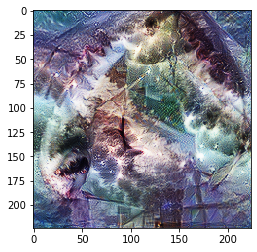

In [9]:
from visual import Channel, TensorImage, BasicAscent, FFTImage
from torchvision.transforms import Normalize

%matplotlib inline

normalize = Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

from visual import transforms

transform = transforms.Compose([
    transforms.SpatialJitter(2),
    transforms.RandomScale([1.1 ** (n / 10.) for n in range(-10, 11)]),
    transforms.RandomRotate(list(range(-5, 6)), padding_mode='border'),
    normalize
])

criterion = Channel(2, 'model') # Great white shark class
image = FFTImage((3, 224, 224), correlate=True, transform=transform).sigmoid()
BasicAscent(image, criterion, steps=256).to_pyplot().run(model, device='cuda', verbose=0)